# Investigation: Hardware Identification via noise fingerprint exploration
The code to produce the circuits is given below. Thereafter the code to run the ideal circuits is given,then the code to run the circuits on hardware, then the code to extract and store the normalised noise profiles.

In [97]:
import qiskit
from qiskit import QuantumCircuit #Aer, IBMQ,
from qiskit.visualization import plot_histogram
from qiskit import transpile
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler

# importing datetime module for now()
import datetime
import matplotlib

## Backends
We ibm_torino is Heron r1, ibm_kingston is Heron r2, ibm_pittsburgh is Heron r3.
Would be interesting to see 2 different hardware with same chip.
https://quantum.cloud.ibm.com/computers

In [2]:
backends = ['ibm_torino','ibm_brisbane']#,'ibm_kingston','ibm_pittsburgh']
#also I think these are the least busy

## Circuits
The circuits are a V shape. They are equivalent to Indentity operations.

![WhatsApp Image 2025-09-13 at 13.21.13_d16e4418.jpg](<attachment:WhatsApp Image 2025-09-13 at 13.21.13_d16e4418.jpg>)
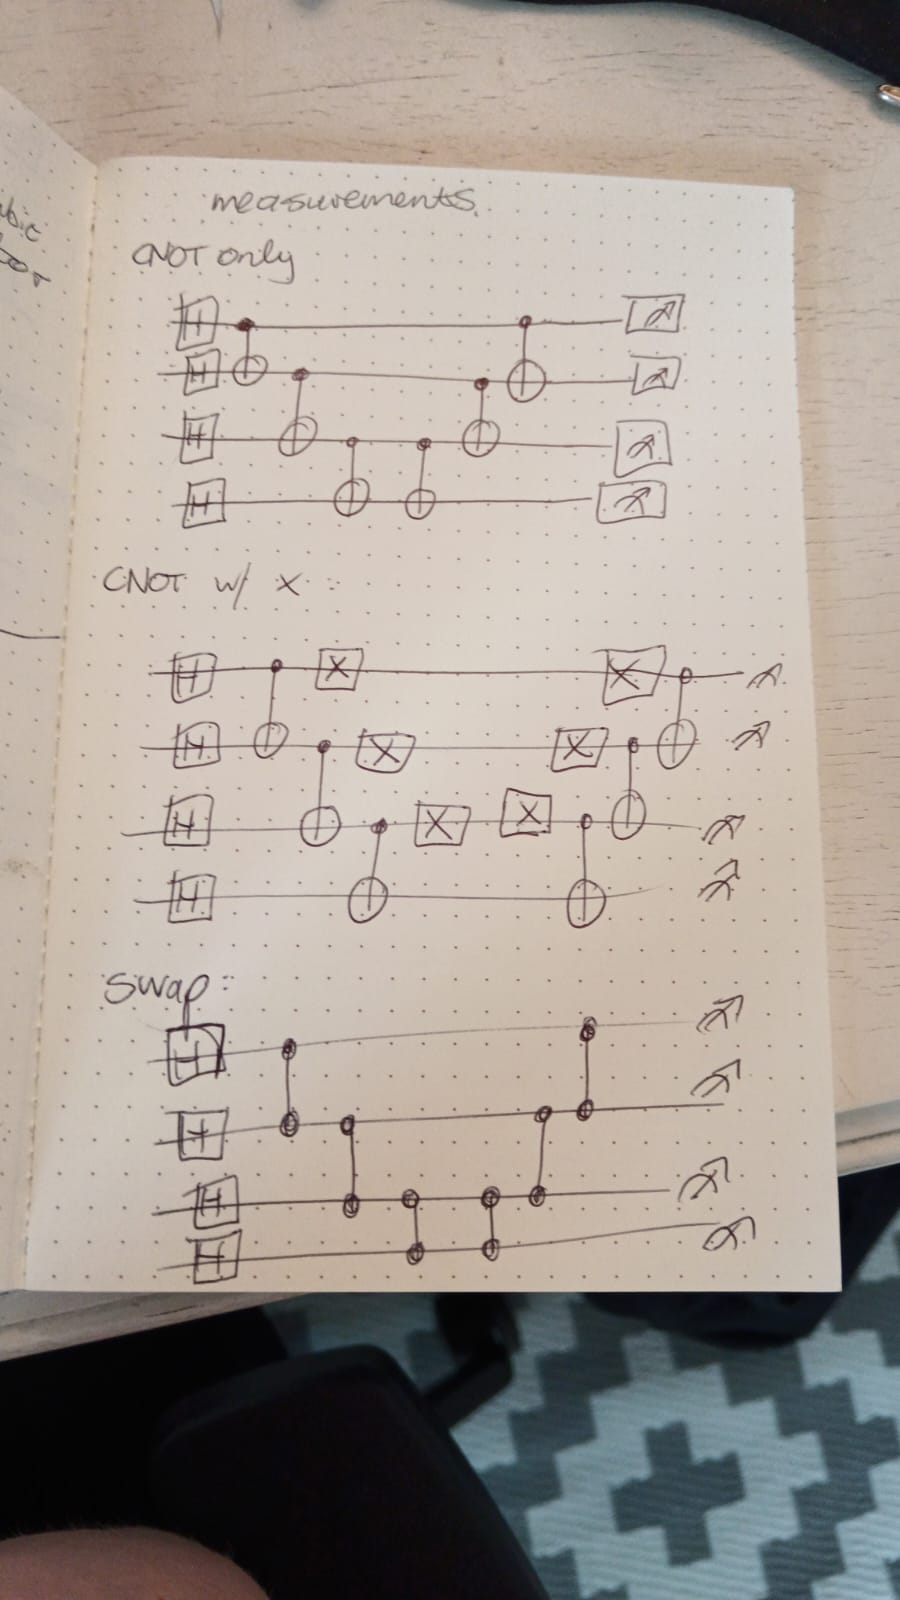

In [3]:
nrs_of_qubits = [4,8,16,32]
circuit_types = ['Cnot','Cnot_X','Swap'] #

In [89]:
#for qubit_nr in nrs_of_qubits:
def make_set_of_3(nr_qubits):
    set_of_3 = []
    for i in range(len(circuit_types)):
        set_of_3.append(make_circuit(nr_qubits,circuit_types[i]))

    return set_of_3

def make_circuit(nr_qubits,circuit_type):
    # make circuit object
    qc = QuantumCircuit(nr_qubits)

    # apply hadamard gates to all qubits
    qc.h(range(nr_qubits))

    #left side of v
    qc = make_left_side(qc,nr_qubits,circuit_type)

    #right side of v
    qc = make_right_side(qc,nr_qubits,circuit_type)

    qc.h(range(nr_qubits))
    #apply measurement gates to all qubits
    qc.measure_all()

    return qc

def make_left_side(qc,nr_qubits,circuit_type):
    #right side of v
    for qubit in range(nr_qubits-1):
        match circuit_type:
            case 'Cnot':
                qc.cx(qubit,qubit+1)
            case 'Cnot_X':
                qc.cx(qubit,qubit+1)
                qc.x(qubit)
            case 'Swap':
                qc.swap(qubit,qubit+1)
    return qc

def make_right_side(qc,nr_qubits,circuit_type):
    #left side of v
    for qubit in range(nr_qubits-2,-1,-1): #start at nr_qubits-1, end at 0, step is -1
        match circuit_type:
            case 'Cnot':
                qc.cx(qubit,qubit+1)
            case 'Cnot_X':
                qc.x(qubit)
                qc.cx(qubit,qubit+1)
            case 'Swap':
                qc.swap(qubit,qubit+1)
    return qc

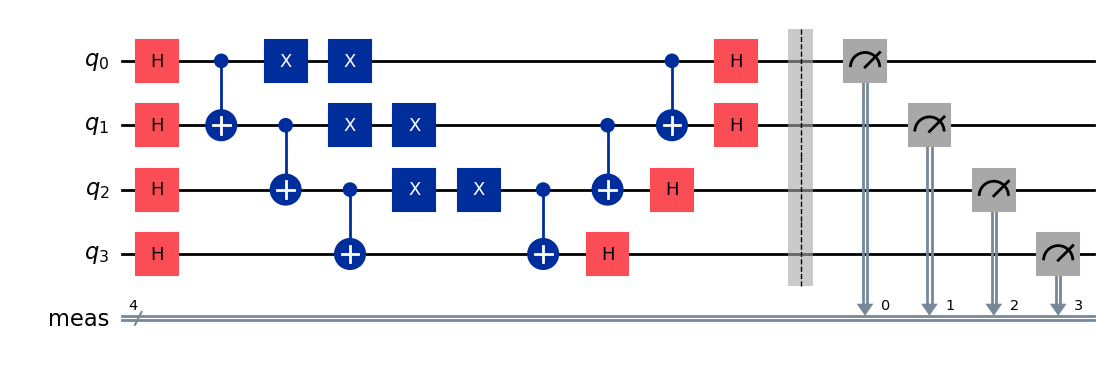

In [92]:
qc = make_circuit(4,'Cnot_X')
qc.draw('mpl')

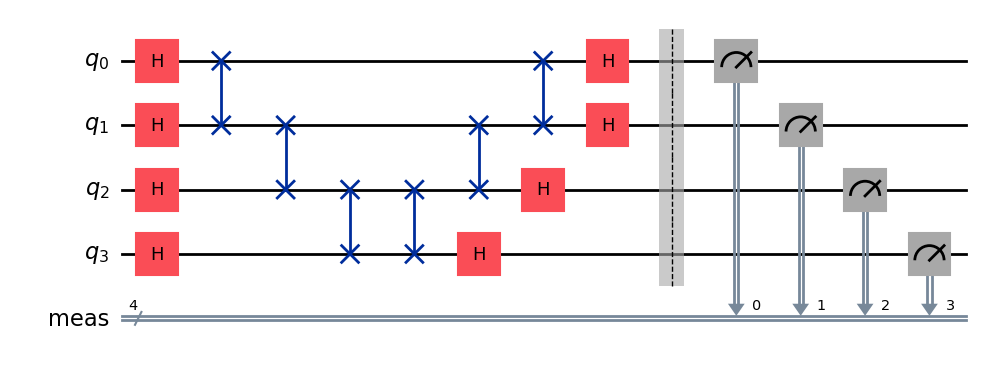

In [91]:
qc_set = make_set_of_3(4)
qc_set[2].draw('mpl')

## Simulated Ideal Results

{'0000': 1000}


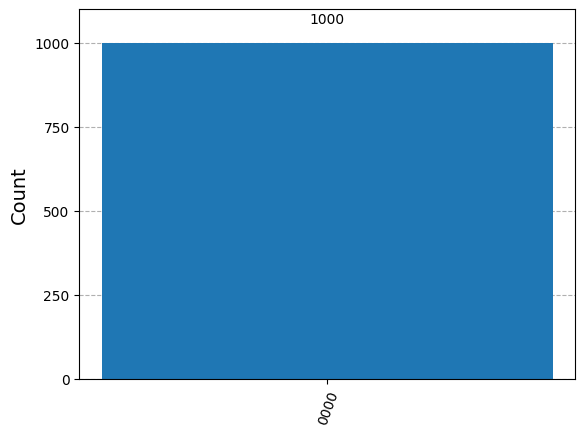

In [90]:
from qiskit.providers.basic_provider import BasicSimulator
nr_qubits= 4
sim_backend = BasicSimulator()
qc_set = make_set_of_3(nr_qubits)[0]

# Transpile the ideal circuit to a circuit that can be directly executed by the backend
transpiled_circuits = transpile(qc_set, sim_backend)

# Run the transpiled circuit using the simulated backend
job = sim_backend.run(transpiled_circuits,shots =1000,memory=True)
result = job.result()

print(result.get_counts())
plot_histogram(result.get_counts())

## Sending Set to IBM backend

In [99]:

def run_job(backend_, circuit_set):
    #transpile circuits
    pm = generate_preset_pass_manager(optimization_level=0, backend=backend_)
    isa_circuits = pm.run(circuit_set)
    sampler = Sampler(mode=backend_)

    #run job
    job = sampler.run(isa_circuits)

    #need code to save job ID
    return job.job_id()

def send_set_to_backends(nr_qubits):
    #make set of circuits:
    qc_set = make_set_of_3(4)
    job_IDs = []
    #send set to each backend
    for backend_name in backends:
        #store the job id for each backend job
        job_IDs.append(run_job(service.backend(backend_name),qc_set))
    return job_IDs


#print(f">>> Job ID: {job.job_id()}")
#print(f">>> Job Status: {job.status()}")

service = QiskitRuntimeService()
#comment out when running the job anew
#Job ID: czwqhvq6rr3g008m9h0g
#job = service.job('czwqhvq6rr3g008m9h0g')

In [ ]:

# using now() to get current time
current_time = datetime.datetime.now().isoformat()
lines = send_set_to_backends(4)
lines.append(current_time)
text = "\n".join(lines) + "\n"
with open("file2.txt", "a", encoding="utf-8") as f:
    f.write(text)

#with open("file2.txt", "r", encoding="utf-8") as f:
   # print(f.read())

a
b
2025-09-14T14:53:22.831450
d33bo2m6pnbs739ie5og
d33bo3u6dbus73d90o50
2025-09-14T14:58:36.290612



In [ ]:
with open("file2.txt", "r", encoding="utf-8") as f:
    print(f.read())